# Projection tutorial

### This tutorial shows how to project points and semantic segmentation on a image.
#### 1.Import required python modules and load sequence data.

In [1]:
import pandaset
import os

# load dataset
dataset = pandaset.DataSet("/data/PandaSet")
seq002 = dataset["002"]
seq002.load()

print("avaliable cameras: ", seq002.camera.keys())

avaliable cameras:  dict_keys(['back_camera', 'front_camera', 'front_left_camera', 'front_right_camera', 'left_camera', 'right_camera'])


#### 2.Use projection function in pandaset.geometry to get projection 2d-points on image.
- ***geometry.projection***
    - input
        - ***lidar_points***(np.array(\[N, 3\])): lidar points in the world coordinates.
        - ***camera_data***(PIL.Image): image for one camera in one frame.
        - ***camera_pose***: pose in the world coordinates for one camera in one frame.
        - ***camera_intrinsics***: intrinsics for one camera in one frame.
        - ***filter_outliers***(bool): filtering projected 2d-points out of image.
    - output
        - ***projection_points2d***(np.array(\[K, 2\])): projected 2d-points in pixels.
        - ***camera_points_3d***(np.array(\[K, 3\])): 3d-points in pixels in the camera frame.
        - ***inliner_idx***(np.array(\[K, 2\])): the indices for *lidar_points* whose projected 2d-points are inside image.

In [2]:
from pandaset import geometry

# generate projected points
seq_idx = 1
camera_name = "front_camera"
lidar = seq002.lidar
points3d_lidar_xyz = lidar.data[seq_idx].to_numpy()[:, :3]
choosen_camera = seq002.camera[camera_name]
projected_points2d, camera_points_3d, inner_indices = geometry.projection(lidar_points=points3d_lidar_xyz, 
                                                                          camera_data=choosen_camera[seq_idx],
                                                                          camera_pose=choosen_camera.poses[seq_idx],
                                                                          camera_intrinsics=choosen_camera.intrinsics,
                                                                          filter_outliers=True)
print("projection 2d-points inside image count:", projected_points2d.shape)

projection 2d-points inside image count: (68659, 2)


#### 3.Show original image.

Populating the interactive namespace from numpy and matplotlib


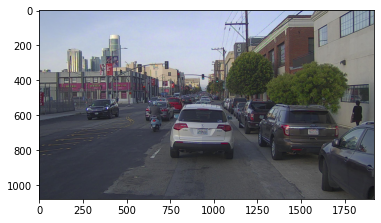

In [3]:
from matplotlib import pyplot as plt
%pylab inline

# image before projection
ori_image = seq002.camera[camera_name][seq_idx]
plt.imshow(ori_image)

#### 4.Show projected points on image colorized by distances.

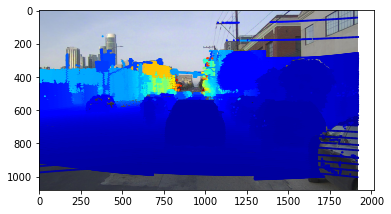

In [4]:
import matplotlib.cm as cm
import numpy as np

# image after projection
plt.imshow(ori_image)
distances = np.sqrt(np.sum(np.square(camera_points_3d), axis=-1))
colors = cm.jet(distances / np.max(distances))
plt.gca().scatter(projected_points2d[:, 0], projected_points2d[:, 1], color=colors, s=1)

#### 5.Show projected points on image colorized by semantic segmentation.

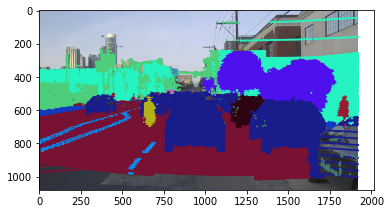

In [5]:
import matplotlib.cm as cm
import numpy as np
import random

# image after projection
plt.imshow(ori_image)

# load semseg
semseg = seq002.semseg[seq_idx].to_numpy()

# get semseg on image by filting outside points
semseg_on_image = semseg[inner_indices].flatten()

# random gnerate colors for semseg
max_seg_id = np.max(semseg_on_image)
color_maps = [(random.random(), random.random(), random.random()) for _ in range(max_seg_id + 1)]
colors = np.array([color_maps[seg_id] for seg_id in semseg_on_image])

plt.gca().scatter(projected_points2d[:, 0], projected_points2d[:, 1], color=colors, s=1)